In [1]:
%load_ext autoreload
%autoreload 2

import networkx as nx 
from matplotlib import pyplot as plt 
import numpy as np

Created 300 edges out of 300 possible edges
NOTICE: The nodes are strings, not integers.


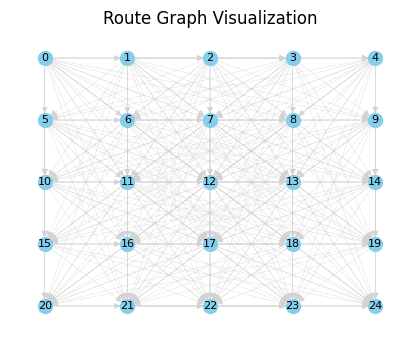

In [2]:
# Create a graph consisting of 25 nodes
# Create a graph with 25 nodes in a 5x5 grid
G = nx.DiGraph()

# Add nodes with attributes
for i in range(25):
    row = i // 5  # Integer division to get row (0-4)
    col = i % 5   # Modulo to get column (0-4)
    G.add_node(str(i), label=i, row=row, col=col, lat=row*0.1, lon=col*0.1)

# Add all possible edges between the 25 nodes (25C2 edges)
for i in range(25):
    for j in range(i+1, 25):  # Start from i+1 to avoid duplicates and self-loops
        # Calculate distance between nodes based on their grid positions
        node_i_row, node_i_col = G.nodes[str(i)]['row'], G.nodes[str(i)]['col']
        node_j_row, node_j_col = G.nodes[str(j)]['row'], G.nodes[str(j)]['col']
        
        # Euclidean distance as edge weight
        distance = np.sqrt((node_i_row - node_j_row)**2 + (node_i_col - node_j_col)**2)
        
        # Add edge with distance as weight
        G.add_edge(str(i), str(j), weight = distance, distance = distance, preference_score = 0.0)

# Print the number of edges to verify
print(f"Created {G.number_of_edges()} edges out of {25*24//2} possible edges")
print(f'NOTICE: The nodes are strings, not integers.')

# Visualize the graph
plt.figure(figsize=(4, 3))

# Get node positions from row and col attributes
pos = {node: (G.nodes[node]['col'], -G.nodes[node]['row']) for node in G.nodes()}

# Draw the graph
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=100, font_size=8, edge_color='lightgray', width=0.25)

# Draw edge weights (distances)
# edge_labels = {(i, j): f"{G[i][j]['weight']:.2f}" for i, j in G.edges()}
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("Route Graph Visualization")
plt.axis('off')  # Turn off axis
plt.show()

In [3]:
import math
import random

def generate_routes(G, node_ori, node_dest):
    """
    Generate 5 different routes from origin to destination node in the graph.
    
    Args:
        G (networkx.Graph): The graph to search
        node_ori (int): Origin node ID
        node_dest (int): Destination node ID
        
    Returns:
        list: List of 5 different paths, where each path is a list of node IDs
    """
    routes = []
    
    # 1. Shortest path (using Dijkstra's algorithm)
    try:
        shortest_path = nx.shortest_path(G, source=node_ori, target=node_dest, weight='weight')
        routes.append(shortest_path)
    except nx.NetworkXNoPath:
        print(f"No path exists between nodes {node_ori} and {node_dest}")
        return []
    
    # 2. Second shortest path using edge removal technique
    temp_graph = G.copy()
    for i in range(len(shortest_path)-1):
        # Temporarily remove each edge in the shortest path and find alternative
        u, v = shortest_path[i], shortest_path[i+1]
        temp_graph.remove_edge(u, v)
        try:
            alt_path = nx.shortest_path(temp_graph, source=node_ori, target=node_dest, weight='weight')
            if alt_path not in routes:
                routes.append(alt_path)
                break
        except nx.NetworkXNoPath:
            pass
        # Restore the edge for next iteration
        temp_graph.add_edge(u, v, weight=G[u][v]['weight'])
    
    # # 3. Multiple paths with random weights (to encourage diversity)
    # for attempt in range(10):  # Try to generate 3 different paths with random weights
    #     rand_graph = G.copy()
    #     for u, v in rand_graph.edges():
    #         # Add random factor to weights with different randomization each time
    #         rand_factor = 0.3 + random.random() * 1.4  # Wider range for more diversity
    #         rand_graph[u][v]['weight'] = G[u][v]['weight'] * rand_factor
        
    #     try:
    #         rand_path = nx.shortest_path(rand_graph, source=node_ori, target=node_dest, weight='weight')
    #         if rand_path not in routes:
    #             routes.append(rand_path)
    #     except nx.NetworkXNoPath:
    #         continue
    
    # 4. Multiple paths with more nodes (longer but potentially more interesting)
    for attempt in range(10):  # Try different variations of the longer path approach
        long_graph = G.copy()
        for u, v in long_graph.edges():
            # Vary the transformation to get different long paths
            if attempt == 0:
                # Standard negative log transformation
                long_graph[u][v]['inv_weight'] = -math.log(G[u][v]['weight'])
            elif attempt == 1:
                # Inverse weight with random factor
                long_graph[u][v]['inv_weight'] = -math.log(G[u][v]['weight'] * (0.7 + random.random() * 0.6))
            else:
                # More extreme transformation to prefer even more hops
                long_graph[u][v]['inv_weight'] = -(math.log(G[u][v]['weight']) ** 2)
        
        try:
            long_path = nx.shortest_path(long_graph, source=node_ori, target=node_dest, weight='inv_weight')
            if long_path not in routes:
                routes.append(long_path)
        except nx.NetworkXNoPath:
            continue
    
    # 5. A* path with custom heuristic
    def heuristic(u, v):
        # Manhattan distance on the grid
        u_row, u_col = G.nodes[u]['row'], G.nodes[u]['col']
        v_row, v_col = G.nodes[v]['row'], G.nodes[v]['col']
        return abs(u_row - v_row) + abs(u_col - v_col)
    
    a_star_path = nx.astar_path(G, source=node_ori, target=node_dest, 
                                heuristic=heuristic, weight='weight')
    if a_star_path not in routes:
        routes.append(a_star_path)
    
    # If we still need more routes, generate some with random walks
    while len(routes) < 20:
        current = node_ori
        path = [current]
        visited = set([current])
        
        while current != node_dest:
            neighbors = list(G.neighbors(current))
            # Filter out already visited nodes if possible
            unvisited = [n for n in neighbors if n not in visited]
            if not unvisited and not neighbors:
                # Dead end with no way to destination
                break
            if not unvisited:
                # If all neighbors visited, allow revisiting
                unvisited = neighbors
            
            # Choose neighbor that's closer to destination with some randomness
            weights = []
            for n in unvisited:
                # Prefer nodes closer to destination
                n_row, n_col = G.nodes[n]['row'], G.nodes[n]['col']
                dest_row, dest_col = G.nodes[node_dest]['row'], G.nodes[node_dest]['col']
                dist_to_dest = math.sqrt((n_row - dest_row)**2 + (n_col - dest_col)**2)
                # Lower distance gets higher weight
                weights.append(1.0 / (dist_to_dest + 0.1))
            
            # Normalize weights
            total = sum(weights)
            weights = [w/total for w in weights]
            
            next_node = random.choices(unvisited, weights=weights)[0]
            path.append(next_node)
            visited.add(next_node)
            current = next_node
            
            # Prevent infinite loops
            if len(path) > 3 * len(G):
                break
        
        if current == node_dest and path not in routes:
            routes.append(path)
    
    # Ensure we return exactly 10 routes (or fewer if impossible)
    return routes[:20]

In [4]:
def plot_routes(G, routes, node_size=200, route_colors=None, line_width=2, alpha=0.7, probabilities=None):
    """
    Plot multiple routes on the graph, each in its own subplot.
    
    Parameters:
    -----------
    G : networkx.Graph
        The graph containing the nodes and edges
    routes : list of lists
        List of routes, where each route is a list of node IDs
    figsize : tuple, optional
        Figure size (width, height) in inches
    node_size : int, optional
        Size of the nodes in the plot
    route_colors : list, optional
        List of colors for each route. If None, colors will be generated automatically
    line_width : int, optional
        Width of the route lines
    alpha : float, optional
        Transparency of the route lines
    """
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    import networkx as nx
    import math
    
    # Calculate grid dimensions
    n_routes = len(routes)
    n_rows, n_cols = 5, 5

    # Automatically determine figure size based on number of routes
    if n_routes <= 4:
        n_rows, n_cols = 2, 2
        figsize = (8, 6)
    elif n_routes <= 9:
        n_rows, n_cols = 3, 3
        figsize = (12, 10)
    elif n_routes <= 16:
        n_rows, n_cols = 4, 4
        figsize = (16, 13)
    else:
        n_rows, n_cols = 5, 5
        figsize = (20, 16)
    
    # Create figure with subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()
    
    # Get node positions from the graph
    pos = {node: (G.nodes[node]['col'], -G.nodes[node]['row']) for node in G.nodes()}
    
    # Generate colors for routes if not provided
    if route_colors is None:
        # Use a colormap to generate distinct colors
        cmap = plt.cm.rainbow
        route_colors = [cmap(i/n_routes) for i in range(n_routes)]
    
    # Plot each route in its own subplot
    for i, route in enumerate(routes):
        if i >= n_rows * n_cols:
            break  # Don't exceed available subplots
            
        ax = axes[i]
        
        # Draw the graph structure (all nodes and edges)
        nx.draw_networkx_nodes(G, pos, node_color='lightgray', node_size=node_size/2, ax=ax)
        nx.draw_networkx_edges(G, pos, edge_color='lightgray', width=0.5, alpha=0.5, ax=ax)
        
        # Draw the route edges
        route_edges = [(route[j], route[j+1]) for j in range(len(route)-1)]
        color = route_colors[i % len(route_colors)]
        
        # Draw the route
        nx.draw_networkx_edges(G, pos, edgelist=route_edges, 
                              edge_color=[color], width=line_width, alpha=alpha, ax=ax)
        
        # Highlight start and end nodes
        nx.draw_networkx_nodes(G, pos, nodelist=[route[0]], 
                              node_color='green', node_size=node_size, ax=ax)
        nx.draw_networkx_nodes(G, pos, nodelist=[route[-1]], 
                              node_color='red', node_size=node_size, ax=ax)
        
        # Add node labels for start and end nodes
        labels = {node: str(node) for node in [route[0], route[-1]]}
        nx.draw_networkx_labels(G, pos, labels=labels, ax=ax)
        if probabilities is not None:
            ax.set_title(f"Route {i}: {route[0]} → {route[-1]}\nProb: {probabilities[i]:.2f}")
        else:
            ax.set_title(f"Route {i}: {route[0]} → {route[-1]}")
        ax.axis('off')
    
    # Hide any unused subplots
    for i in range(n_routes, n_rows * n_cols):
        axes[i].axis('off')
    
    plt.suptitle(f"Graph with {n_routes} routes", fontsize=16)
    plt.tight_layout()
    return fig


# Route Cluster 1: 0 → 24

In [5]:
# Set random seed for reproducibility
import random
random.seed(69420)

routes_0_24 = generate_routes(G, '0', '24')


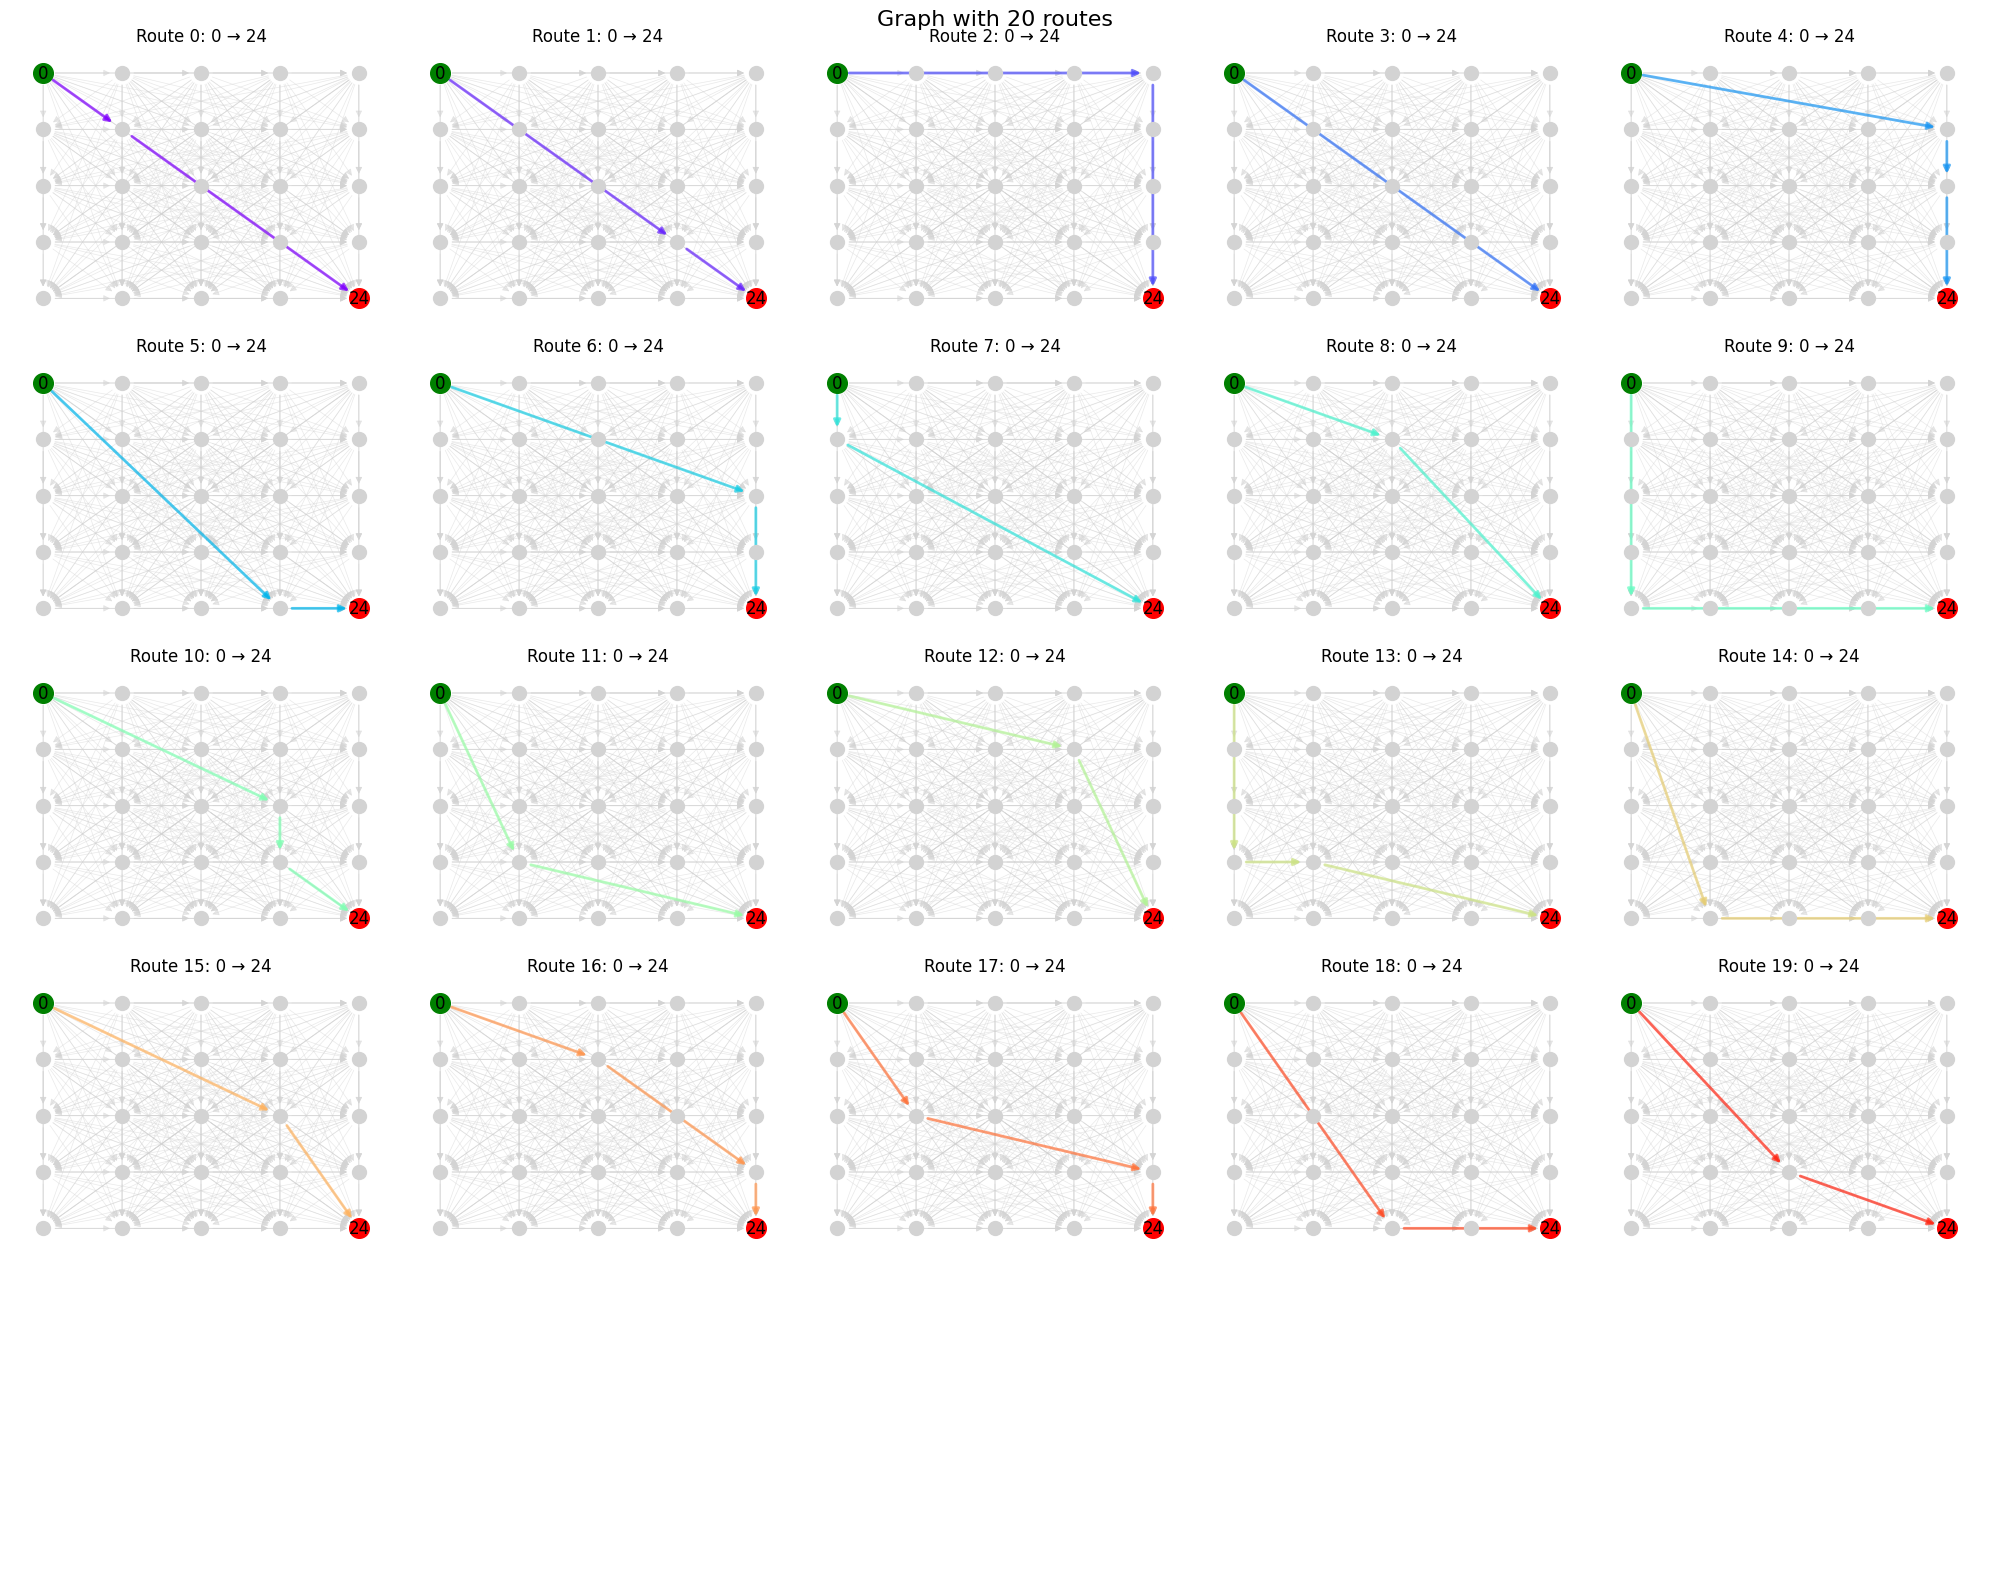

In [6]:
plot_routes(G, routes_0_24)
plt.show()


In [7]:
routes_0_24_final = [routes_0_24[x] for x in [0, 1, 6, 8, 9, 10, 15, 18]]
# Create a random probability distribution for the routes
probabilities = np.random.rand(len(routes_0_24_final))

# Normalize the probabilities to sum to 1
routes_0_24_final_prob = [p / sum(probabilities) for p in probabilities]

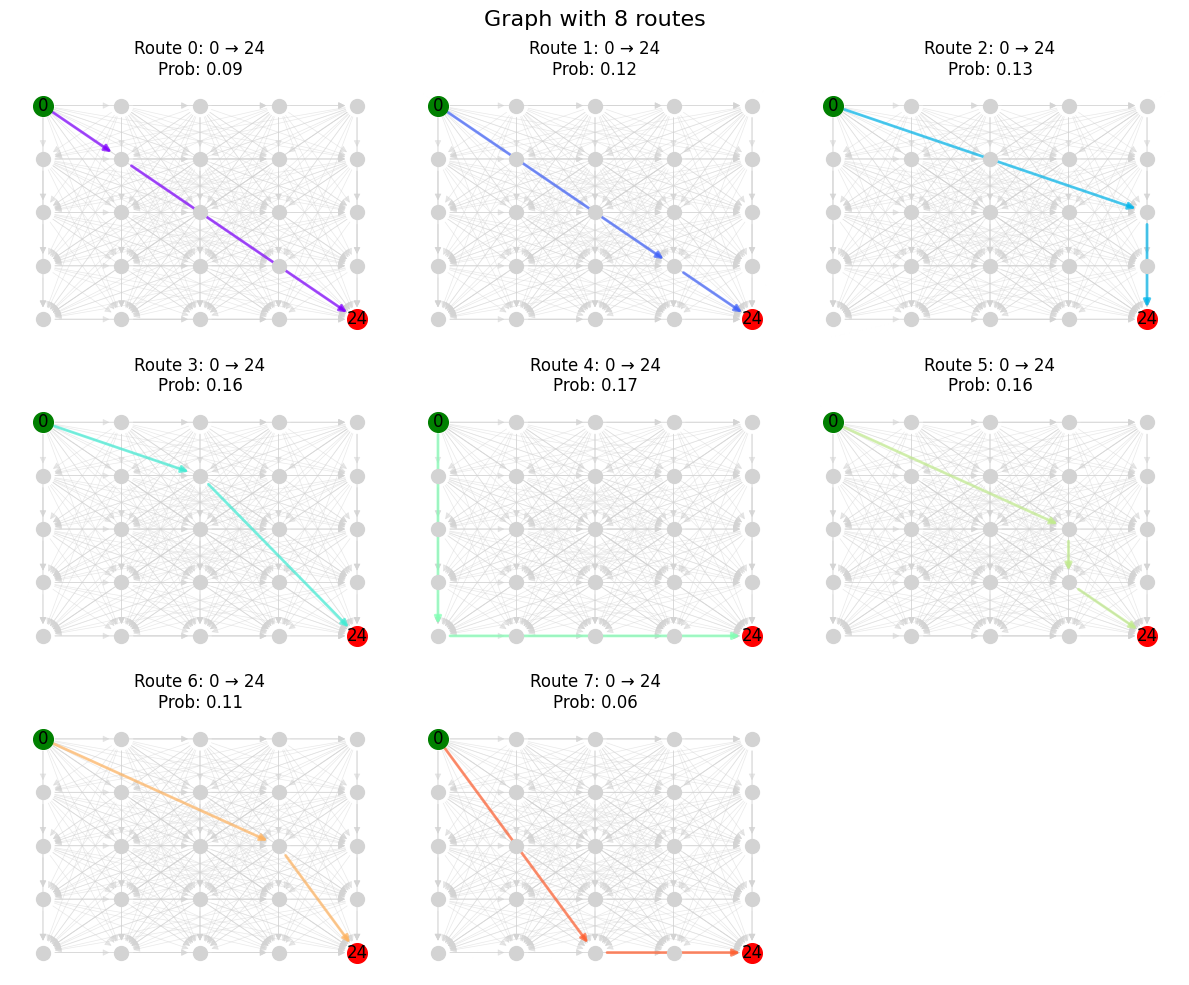

In [8]:
plot_routes(G, routes_0_24_final, probabilities=routes_0_24_final_prob)
plt.show()

# QUASAR-R-Zero

- Routing Module
- Zero Edge Dependency

## Gradient Descent with Multiple Restarts for Model Learning

In [9]:
N_demonstrations = 899
# Sample N_demonstrations routes from routes_0_24_final with probability routes_0_24_final_prob
demonstrations = []
for _ in range(N_demonstrations):
    # Sample a route based on the probability distribution
    sampled_route_idx = random.choices(range(len(routes_0_24_final)), weights=routes_0_24_final_prob, k=1)[0]
    demonstrations.append(routes_0_24_final[sampled_route_idx])

# Count occurrences of each route in demonstrations
route_counts = {}
for route in demonstrations:
    route_tuple = tuple(route)  # Convert list to tuple for hashing
    if route_tuple in route_counts:
        route_counts[route_tuple] += 1
    else:
        route_counts[route_tuple] = 1

# Print statistics about the sampled demonstrations
print(f"Sampled {N_demonstrations} demonstrations")
print("Route distribution in demonstrations:")
for route_tuple, count in route_counts.items():
    percentage = (count / N_demonstrations) * 100
    print(f"Route {list(route_tuple)}: {count} occurrences ({percentage:.2f}%)")

Sampled 899 demonstrations
Route distribution in demonstrations:
Route ['0', '18', '24']: 112 occurrences (12.46%)
Route ['0', '14', '24']: 108 occurrences (12.01%)
Route ['0', '20', '24']: 122 occurrences (13.57%)
Route ['0', '13', '18', '24']: 149 occurrences (16.57%)
Route ['0', '7', '24']: 147 occurrences (16.35%)
Route ['0', '6', '24']: 87 occurrences (9.68%)
Route ['0', '22', '24']: 54 occurrences (6.01%)
Route ['0', '13', '24']: 120 occurrences (13.35%)


In [23]:
from bellman_ford import optimize_preferences_with_restarts

GX = G.copy()

start_node = '0'
target_node = '24'
alpha = 1.0       # Weight for preference score in cost
alpha_r = 0.01    # Regularization strength (L2)
learning_rate = 0.25 # Step size for gradient descent
num_epochs = 10_000    # Number of optimization iterations
initial_preference = 0.0 # Initial guess for preference scores
convergence_threshold = 1e-5 # Stop if max gradient component is small

optimized_graph, history = optimize_preferences_with_restarts(
        graph=GX,
        demonstrations=demonstrations,
        start_node=start_node,
        target_node=target_node,
        alpha=alpha,
        alpha_r=alpha_r,
        learning_rate=learning_rate,
        num_epochs=num_epochs,
        initial_preference=initial_preference,
        convergence_threshold=convergence_threshold,
        early_stopping_patience=1000,
        init_std=3.0,
        num_restarts=3
    )


Restart 1/3
Calculated Empirical Visitations (E_D). Example: {('0', '18'): 0.12458286985539488, ('18', '24'): 0.2903225806451613, ('0', '14'): 0.12013348164627363, ('14', '24'): 0.12013348164627363, ('0', '20'): 0.135706340378198}


 36%|███▌      | 3576/10000 [00:37<01:07, 94.82it/s, Epoch=3577, Loss=3.1615e+00, Grad Norm=3.8631e-05, Max Grad=9.9877e-06]



Convergence reached at epoch 3577. Max gradient below threshold.
Restart 1 final loss: 3.1615e+00

Restart 2/3
Calculated Empirical Visitations (E_D). Example: {('0', '18'): 0.12458286985539488, ('18', '24'): 0.2903225806451613, ('0', '14'): 0.12013348164627363, ('14', '24'): 0.12013348164627363, ('0', '20'): 0.135706340378198}


 35%|███▌      | 3516/10000 [00:37<01:08, 95.00it/s, Epoch=3517, Loss=3.1615e+00, Grad Norm=4.1139e-05, Max Grad=9.9904e-06]



Convergence reached at epoch 3517. Max gradient below threshold.
Restart 2 final loss: 3.1615e+00

Restart 3/3
Calculated Empirical Visitations (E_D). Example: {('0', '18'): 0.12458286985539488, ('18', '24'): 0.2903225806451613, ('0', '14'): 0.12013348164627363, ('14', '24'): 0.12013348164627363, ('0', '20'): 0.135706340378198}


 35%|███▌      | 3533/10000 [00:37<01:09, 93.02it/s, Epoch=3534, Loss=3.1615e+00, Grad Norm=3.9102e-05, Max Grad=9.9803e-06]


Convergence reached at epoch 3534. Max gradient below threshold.
Restart 3 final loss: 3.1615e+00

Best loss after 3 restarts: 3.1615e+00


## Inspection of Results

In [24]:
from dotenv import load_dotenv
load_dotenv()

import os 

PROJECT_ROOT = os.getenv("PROJECT_ROOT")
# Add PROJECT_ROOT to Python search path 

import sys 
sys.path.append(PROJECT_ROOT)

In [25]:
from bellman_ford import calculate_edge_costs

def add_edge_cost_to_graph(graph, alpha = 1.0):
    # Calculate costs using the existing function and preferences from optimized_graph
    costs = calculate_edge_costs(graph, alpha)
    return_graph = graph.copy()

    # Add costs as a property to each edge in the graph
    for (u, v), cost in costs.items():
        return_graph.edges[u, v]['cost'] = cost
    return return_graph

optimized_graph_with_costs = add_edge_cost_to_graph(optimized_graph)

In [26]:
for edge in optimized_graph_with_costs.edges():
    print(f'Edge {edge}: DIST = {optimized_graph_with_costs.edges[edge]["distance"]:.2f} PREF = {optimized_graph_with_costs.edges[edge]["preference_score"]:.2f} COST = {optimized_graph_with_costs.edges[edge]["cost"]:.2f}')

Edge ('0', '1'): DIST = 1.00 PREF = -2.68 COST = 3.68
Edge ('0', '2'): DIST = 2.00 PREF = -1.97 COST = 3.97
Edge ('0', '3'): DIST = 3.00 PREF = -1.24 COST = 4.24
Edge ('0', '4'): DIST = 4.00 PREF = -0.56 COST = 4.56
Edge ('0', '5'): DIST = 1.00 PREF = -2.20 COST = 3.20
Edge ('0', '6'): DIST = 1.41 PREF = -0.72 COST = 2.14
Edge ('0', '7'): DIST = 2.24 PREF = 0.29 COST = 1.95
Edge ('0', '8'): DIST = 3.16 PREF = -0.85 COST = 4.02
Edge ('0', '9'): DIST = 4.12 PREF = -0.38 COST = 4.51
Edge ('0', '10'): DIST = 2.00 PREF = -1.14 COST = 3.14
Edge ('0', '11'): DIST = 2.24 PREF = -1.09 COST = 3.32
Edge ('0', '12'): DIST = 2.83 PREF = -0.83 COST = 3.66
Edge ('0', '13'): DIST = 3.61 PREF = 2.68 COST = 0.93
Edge ('0', '14'): DIST = 4.47 PREF = 2.86 COST = 1.61
Edge ('0', '15'): DIST = 3.00 PREF = -0.45 COST = 3.45
Edge ('0', '16'): DIST = 3.16 PREF = -0.41 COST = 3.57
Edge ('0', '17'): DIST = 3.61 PREF = -0.30 COST = 3.90
Edge ('0', '18'): DIST = 4.24 PREF = 2.74 COST = 1.50
Edge ('0', '19'): DIST 

In [ ]:
from bellman_ford import calculate_empirical_visitations, calculate_expected_visitations, soft_bellman_ford, calculate_transition_probs
ED = calculate_empirical_visitations(G, demonstrations)
print(f'Empirical Visitation Distribution:')
for edge, count in ED.items():
    print(f'Edge {edge}: Visits={count}')


print(f'---')
print(f'Model Visitation Distribution:')
costs = calculate_edge_costs(optimized_graph_with_costs, alpha)
V_soft = soft_bellman_ford(optimized_graph_with_costs, target_node, costs)

# 3. Calculate transition probabilities
transition_probs = calculate_transition_probs(optimized_graph_with_costs, costs, V_soft)

# 4. Calculate expected state and edge visitations
D, E_pi = calculate_expected_visitations(optimized_graph_with_costs, start_node, target_node, transition_probs)
for edge, expected_visitation in E_pi.items():
    print(f'Edge {edge}: Visits={expected_visitation}')

Empirical Visitation Distribution:
Edge ('0', '18'): Visitation=0.12458286985539488
Edge ('18', '24'): Visitation=0.2903225806451613
Edge ('0', '14'): Visitation=0.12013348164627363
Edge ('14', '24'): Visitation=0.12013348164627363
Edge ('0', '20'): Visitation=0.135706340378198
Edge ('20', '24'): Visitation=0.135706340378198
Edge ('0', '13'): Visitation=0.2992213570634038
Edge ('13', '18'): Visitation=0.1657397107897664
Edge ('0', '7'): Visitation=0.1635150166852058
Edge ('7', '24'): Visitation=0.1635150166852058
Edge ('0', '6'): Visitation=0.0967741935483871
Edge ('6', '24'): Visitation=0.0967741935483871
Edge ('0', '22'): Visitation=0.060066740823136816
Edge ('22', '24'): Visitation=0.060066740823136816
Edge ('13', '24'): Visitation=0.13348164627363737
---
Model Visitation Distribution:
Edge ('0', '1'): Visitation=0.02679544246810608
Edge ('0', '2'): Visitation=0.01974194157569343
Edge ('0', '3'): Visitation=0.012425846064040248
Edge ('0', '4'): Visitation=0.005640169638196805
Edge (

## Sampling from the new graph

In [28]:
# Sample 1000 routes from the optimized graph 

import lateral.planner_pivot_with_heuristics_lean_fix1100 as mcmc
MAX_ITER = 10_000
BURN_IN = 5_000 # can go as high as 10_000
THINNING = 50 # can go as high as 50 
sampled_routes = []
temperature = 1.0

total_accepted = 0

# Find the shortest path between 0 and 24
# shortest_path = nx.shortest_path(G, source='0', target='24', weight='weight')
shortest_path = ['0', '12', '24']
print(f'Shortest path: {shortest_path}')
route = shortest_path 

import time 
start_time = time.time()
for i in range(MAX_ITER):
    new_route, accepted = mcmc.mcmc_step(optimized_graph_with_costs, route, temperature = 10.0, verbose = False,
                                    max_depth=8, collapse_pivot=False)
    
    print(f'{i < BURN_IN and "Burn-in" or "Sampling"} | Iteration {i+1}, accepted: {total_accepted}               ', end='\r')
    
    if accepted:
        route = new_route
        
    if i > BURN_IN: # Sampling phase
        if accepted:
            total_accepted += 1
        if i % THINNING == 0:
            sampled_routes.append(route)
        
print(f"Total chain time: {time.time() - start_time:.2f} seconds. Total accepted: {total_accepted}/{MAX_ITER - BURN_IN}")


Shortest path: ['0', '12', '24']
Total chain time: 2.18 seconds. Total accepted: 1787/5000


In [29]:
def compute_route_probabilities(sampled_routes):
    # Count occurrences of each unique route
    route_counts = {}
    for route in sampled_routes:
        # Convert list to tuple to make it hashable for dictionary keys
        route_tuple = tuple(route)
        route_counts[route_tuple] = route_counts.get(route_tuple, 0) + 1
    
    # Calculate total number of routes
    total_routes = len(sampled_routes)
    
    # Calculate probability for each unique route
    route_probabilities = {route: count / total_routes 
                           for route, count in route_counts.items()}
    
    return route_probabilities  # or return route_probabilities if you prefer tuples

sampled_routes_proba = compute_route_probabilities(sampled_routes)

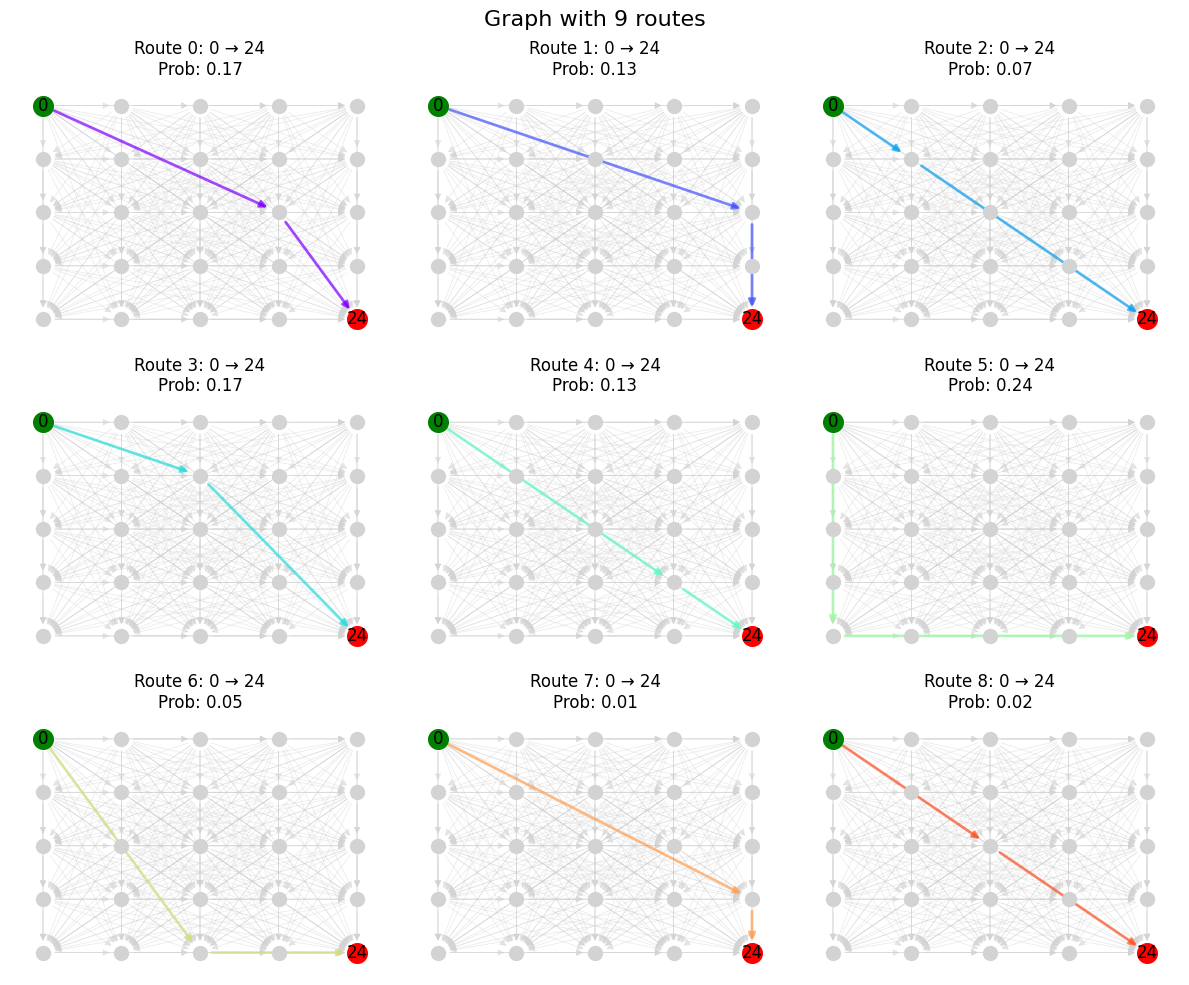

In [30]:
# Extract keys (routes) and values (probabilities) from the dictionary
unique_routes = list(sampled_routes_proba.keys())
route_probabilities = list(sampled_routes_proba.values())

# Convert tuple routes back to lists if needed
unique_routes = [list(route) for route in unique_routes]

# Plot with the extracted data
plot_routes(G, unique_routes, probabilities=route_probabilities)
plt.show()

For debugging:

In [ ]:
from bellman_ford import calculate_empirical_visitations, calculate_expected_visitations, soft_bellman_ford, calculate_transition_probs
ED = calculate_empirical_visitations(G, demonstrations)
print(f'Empirical Visitation Distribution:')
for edge, count in ED.items():
    print(f'Edge {edge}: Visitation={count}')


print(f'---')
print(f'Model Visitation Distribution:')
costs = calculate_edge_costs(optimized_graph_with_costs, alpha)
V_soft = soft_bellman_ford(optimized_graph_with_costs, target_node, costs)

# 3. Calculate transition probabilities
transition_probs = calculate_transition_probs(optimized_graph_with_costs, costs, V_soft)

# 4. Calculate expected state and edge visitations
D, E_pi = calculate_expected_visitations(optimized_graph_with_costs, start_node, target_node, transition_probs)
for edge, expected_visitation in E_pi.items():
    print(f'Edge {edge}: Visitation={expected_visitation}')

In [ ]:
# Call Bellman-Ford to debug
from bellman_ford import optimize_preferences
_, __ = optimize_preferences(
        graph=GX, # GX and optimized_graph_with_costs are the same graph
        demonstrations=demonstrations,
        start_node=start_node,
        target_node=target_node,
        alpha=alpha,
        alpha_r=alpha_r,
        learning_rate=learning_rate,
        num_epochs=num_epochs,
        initial_preference=initial_preference,
        convergence_threshold=convergence_threshold,
        early_stopping_patience=1000,
        infer_mode=True
    )